# Training with PyTorch

**Note: `aenet-python` needs to be installed with the `[torch]` requirements (`pip install aenet[torch]`) for this notebook to work.**

This notebook demonstrates end-to-end training using the PyTorch trainer with on-the-fly featurization.

In [1]:
import glob
import os
import torch

outdir = './example-05-outputs/'

print(torch.__version__)

2.9.0


## 1. Featurizer configuration

The PyTorch-based training implementation does not require a separate feturization step.  It can featurize the structures on-the-fly during training, although it also supports caching the features in memory or in an HDF5 file.

This means, the featurizer needs to be passed to the training method as an argument and has to be set up separately.

Note: The data type used by the featurizer (32-bit or 64-bit floats) will be used for all remaining steps by default.

In [2]:
from aenet.torch_featurize import ChebyshevDescriptor

descr = ChebyshevDescriptor(
    species=["Ti", "O"],
    rad_order=10,
    rad_cutoff=6.0,
    ang_order=3,
    ang_cutoff=3.5,
    min_cutoff=0.5,
    device="cpu",
    dtype=torch.float64,
)

# 2. Energy-only training

The other ingredients needed for energy-only training are

1. The ANN architecture,
2. The element-wise atomic energies,<sup>1</sup>
3. (Optionally) a config with the training parameters, and
4. A list of paths to XSF files.<sup>2</sup>

<sup>1</sup>By default, the cohesive energy is the training target and recommended. 

<sup>2</sup>The `train()` method also accepts lists of `AtomicStructure` objects.  More advanced data handling is possible using data sets (from `aenet.torch_training.dataset`). 

Energy-only training can benefit significantly from feature caching, i.e., the local atomic environment descriptor is only evaluated once for each structure and then kept in memory.  This is feasible for moderately-sized data sets.

In [3]:
from aenet.torch_training import TorchANNPotential, TorchTrainingConfig, Adam

arch = {
    'Ti': [(10, 'tanh'), (10, 'tanh')],
    'O': [(10, 'tanh'), (10, 'tanh')]
}

pot = TorchANNPotential(arch, descriptor=descr)

# Configure training
cfg = TorchTrainingConfig(
    atomic_energies={'O': -432.503149303, 'Ti': -1604.604515075},
    testpercent=10,
    # optimization parameters
    iterations=500,
    method=Adam(mu=0.001, batchsize=32),
    use_scheduler=True,  # for learning-rate adjustment
    scheduler_patience=10,
    # caching: keep features in memory
    cache_features=True,
    # store checkpoints for restarting
    checkpoint_dir=os.path.join(outdir, "chkpt"),
    checkpoint_interval=5,
    max_checkpoints=3,
    save_best=True,
)

results = pot.train(
    structures=glob.glob("./xsf-TiO2/*.xsf"),
    config=cfg
)

pot.save(os.path.join(outdir, '01_energy_training.pt'))

Training: 100%|█| 500/500 [00:02<00:00, 215.14it/s, trE=0.1212, lr=1.00e-06, fwd


# 3. Inspection of the results

Once the training has completed, the results can be inspected with the `TrainOutput` class.

In [4]:
print(results)

Training statistics:
  final_MAE_train: 0.06855011986937844
  final_RMSE_train: 0.12123150494551367
  final_MAE_test: 0.07449727528811609
  final_RMSE_test: 0.1110648054071108
  min_RMSE_test: 0.10183174524731384
  epoch_min_RMSE_test: 61
  final_RMSE_force_train: nan
  final_RMSE_force_test: nan
  min_RMSE_force_test: nan
  epoch_min_RMSE_force_test: 1



Generate a plot of the train/validation set RMSE:

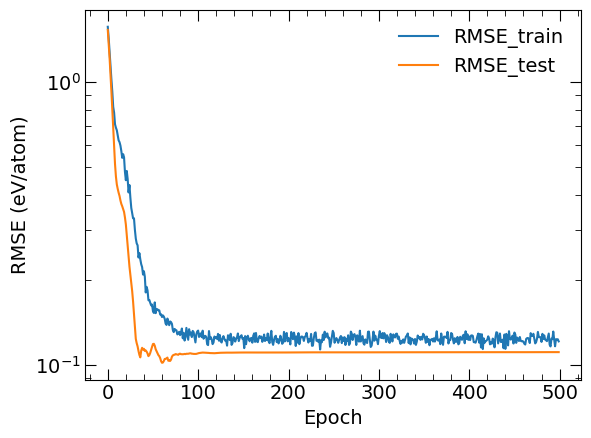

In [5]:
results.plot_training_errors()

# 4. Force training

Training on both energies and forces is computationally significantly more demanding and memory intensive.  Feature caching is not effective for the gradient evaluation required for force training, and therefore additional caching of neighbor lists and triplet vectors is available.  Typically, a fraction of all structures is randomly selected for force training to achieve a reasonable balance of efficiency and accuracy.

Note: Although, we are ressuming the training from the best model obtained from energy-only training above, the train:test split is not the same with this approach. For a static train:test split, data sets can be used.

In [13]:
%%time

# Configure training
cfg = TorchTrainingConfig(
    atomic_energies={'O': -432.503149303, 'Ti': -1604.604515075},
    iterations=100,
    testpercent=10,
    force_weight=0.25,
    force_fraction=0.5,
    method=Adam(mu=0.001, batchsize=8),
    use_scheduler=True,  # for learning-rate adjustment
    scheduler_patience=50,
    # Caching
    cache_features=True,
    cache_force_neighbors=True,
    cache_force_triplets=True,
    force_scale_unbiased=True,
    # Parallelization
    num_workers=4,
    prefetch_factor=2,
    # Hardware/device selection
    memory_mode="cpu",
    device="cpu",
    # store checkpoints for restarting
    checkpoint_dir=os.path.join(outdir, "chkpt2"),
    checkpoint_interval=5,
    max_checkpoints=3,
    save_best=True,
)

# Train model (returns TrainOut object)
results2 = pot.train(
    structures=glob.glob("./xsf-TiO2/*.xsf"),
    resume_from=os.path.join(outdir, "chkpt", "best_model.pt"),
    config=cfg
)

pot.save(os.path.join(outdir, '02_force_training.pt'))

Training: 100%|█| 100/100 [01:41<00:00,  1.02s/it, trE=0.06793, lr=2.50e-04, fwd


CPU times: user 31.9 s, sys: 7.22 s, total: 39.1 s
Wall time: 1min 53s


For force training, the convenience method `plot_training_summary()` plots both the energy and force RMSE history.

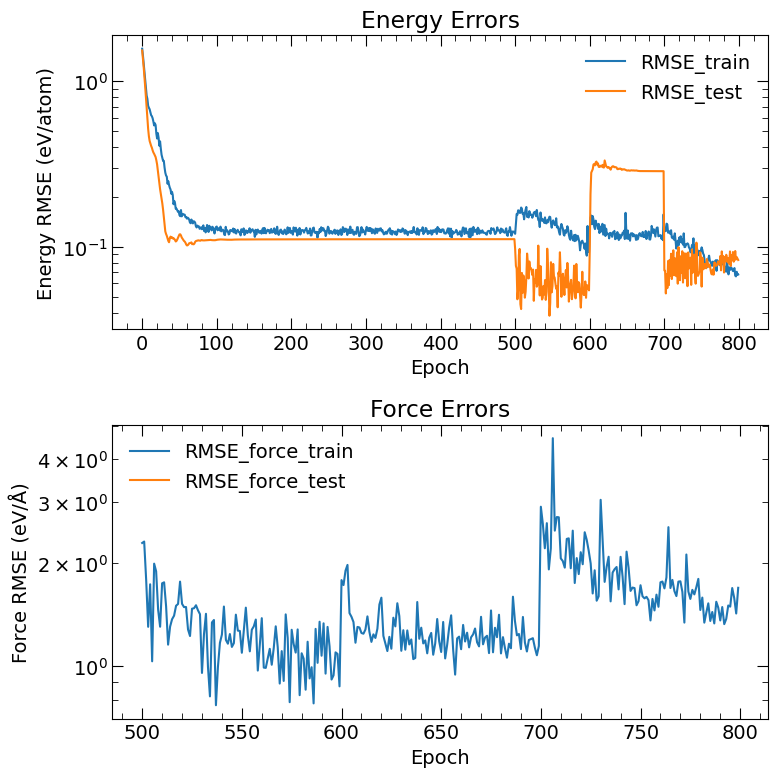

In [14]:
results2.plot_training_summary()

# 5. Model metadata

Models that were saved with `.save()` or in checkpoint files come with some additional metadata.

In [8]:
pot2 = TorchANNPotential.from_file('./example-05-outputs/02_force_training.pt')
pot2.metadata.keys()

dict_keys(['schema_version', 'timestamp', 'torch_version', 'device_hint', 'architecture', 'descriptor_config', 'optimizer_state_dict', 'training_history', 'best_val_loss', 'training_config', 'extra_metadata', 'normalization', 'atomic_energies'])

This metadata includes the descriptor and training configs.

In [9]:
print(pot2.metadata['descriptor_config'])
print('-----')
print(pot2.metadata['training_config'])

{'species': ['Ti', 'O'], 'rad_order': 10, 'rad_cutoff': 6.0, 'ang_order': 3, 'ang_cutoff': 3.5, 'min_cutoff': 0.5, 'dtype': 'float64', 'device': 'cpu', 'n_features': 30}
-----
{'iterations': 100, 'method': {'name': 'adam', 'mu': 0.001, 'batchsize': 8, 'weight_decay': 0.0, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-08}, 'testpercent': 10, 'force_weight': 0.5, 'force_fraction': 0.1, 'force_sampling': 'random', 'force_resample_each_epoch': True, 'force_min_structures_per_epoch': 1, 'force_scale_unbiased': True, 'cache_features': True, 'cache_force_neighbors': True, 'cache_force_triplets': True, 'cache_persist_dir': None, 'cache_scope': 'all', 'epochs_per_force_window': 1, 'memory_mode': 'cpu', 'max_energy': None, 'max_forces': None, 'save_energies': False, 'save_forces': False, 'timing': False, 'device': 'cpu', 'precision': 'auto', 'atomic_energies': {'O': -432.503149303, 'Ti': -1604.604515075}, 'normalize_features': True, 'normalize_energy': True, 'num_workers': 4, 'prefetch_factor': 2,

Also included is the PyTorch version (`torch_version`) and the version of the model file schema (`schema_version`) in case of breaking changes in the future.

In [10]:
pot2.metadata['schema_version']

'1.0'